In [2]:
import rnaseqpoptools as rnaseqpop
import pandas as pd
import numpy as np
import allel

In [3]:
# Read in parameters from snakemake
dataset = "Ag_Busia"
metadata = pd.read_csv("../../config/samples.tsv", sep="\t")
metadata = metadata.sort_values(by='species')
contigs = ['2L', '2R', '3L','3R', 'X']
ploidy = 10
numbers = rnaseqpop.get_numbers_dict(ploidy)
qualflt = 30
missingprop = 0

In [7]:
def windowedDiversity(geno, pos, subpops, contig, statistic='pi', window_size=20000):
    ### Estimate in 20kb windows separately
    pi_dict = {}
    for pop, idx in subpops.items():
        ac = geno.take(idx, axis=1).count_alleles()
        if statistic == 'pi':
            pi, windows, d, f = allel.windowed_diversity(pos, ac, size=window_size)
        elif statistic == 'theta':
            pi, windows, d, f = allel.windowed_watterson_theta(pos, ac, size=window_size)
        else:
            assert "statistic is neither pi or theta"
        pi_dict[pop] = pd.DataFrame(pi).rename(columns={0:statistic})

    pi = pd.concat(pi_dict).reset_index().rename(columns={'level_0':'treatment'})
    return(pi)

def diversity_ci_table(dl):
    import math
    div_stat = pd.concat(dl)
    stats = div_stat.groupby(['treatment'])['pi'].agg(['mean', 'count', 'std'])
    print('-'*30)

    ci95_hi = []
    ci95_lo = []
    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo
    return(stats)

In [5]:
dl = {}
for i, contig in enumerate(contigs):
    
    # Read in and Filter VCF
    path = f"../../results/variantAnalysis/vcfs/{dataset}.{contig}.vcf.gz"
    vcf, geno, acsubpops, pos, depth, snpeff, subpops, populations = rnaseqpop.readAndFilterVcf(path=path,
                                                           chrom=contig,
                                                           samples=metadata,
                                                           numbers=numbers,
                                                           ploidy=ploidy,
                                                           qualflt=qualflt,
                                                           missingfltprop=missingprop)
    ### Estimate in 20kb windows separately

    dl[contig] = windowedDiversity(geno=geno, subpops=subpops, contig=contig, statistic='pi', window_size=20_000)



-------------- Reading VCF for chromosome 2L --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 0 -------
QUAL filter will retain 322603 SNPs retained out of 396426 for chromosome 2L
Missingness filter will retain 396426 SNPs out of 396426 for chromosome 2L
The combined filter will retain 322603 SNPs out of 396426 for chromosome 2L

-------------- Reading VCF for chromosome 2R --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 0 -------
QUAL filter will retain 437795 SNPs retained out of 533960 for chromosome 2R
Missingness filter will retain 533960 SNPs out of 533960 for chromosome 2R
The combined filter will retain 437795 SNPs out of 533960 for chromosome 2R

-------------- Reading VCF for chromosome 3L --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 0 -------
QUAL filter will retain 217180 SNPs retained out of 276206 for chromosome 3L
Missingness filter will retain 276206 SNPs out of 276206 for chro

In [8]:
diversity_ci_table(dl=dl)

------------------------------


,mean,count,std,ci95_hi,ci95_lo
treatment,,,,,
BusiaParental,0.001099,11525,0.001313,0.001123,0.001075
BusiaSelected,0.000791,11525,0.001135,0.000811,0.000770
Kisumu,0.000618,11525,0.000954,0.000635,0.000600


In [4]:
pi = pd.concat(dl)

In [5]:
stats = pi.groupby(['treatment'])['pi'].agg(['mean', 'count', 'std'])
import math
print(stats)
print('-'*30)

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)



                   mean  count       std
treatment                               
BusiaParental  0.001042  11525  0.001283
BusiaSelected  0.000707  11525  0.001081
Kisumu         0.000618  11525  0.000954
------------------------------
                   mean  count       std   ci95_hi   ci95_lo
treatment                                                   
BusiaParental  0.001042  11525  0.001283  0.001065  0.001018
BusiaSelected  0.000707  11525  0.001081  0.000727  0.000687
Kisumu         0.000618  11525  0.000954  0.000635  0.000600


In [9]:
%matplotlib inline

In [17]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='treatment', ylabel='mean'>

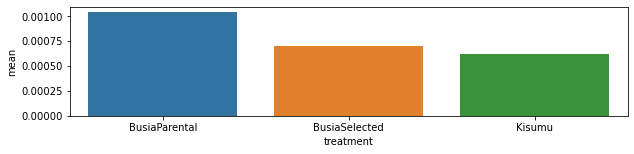

In [18]:
fig, ax = plt.subplots(1,1, figsize=[10,2])
sns.barplot(data=stats.reset_index(), x="treatment", y="mean")

In [170]:
### Wattersons theta
dl = {}
for i, contig in enumerate(contigs):
    
    # Read in and Filter VCF
    path = f"../../results/variantAnalysis/vcfs/{dataset}.{contig}.vcf.gz"
    vcf, geno, acsubpops, pos, depth, snpeff, subpops, populations = rnaseqpop.readAndFilterVcf(path=path,
                                                           chrom=contig,
                                                           samples=metadata,
                                                           numbers=numbers,
                                                           ploidy=ploidy,
                                                           qualflt=qualflt,
                                                           missingfltprop=missingprop)
    pi_dict = {}
    for key, idx in subpops.items():
        ac = geno.take(idx[:4], axis=1).count_alleles()
        pi, windows, d, f = allel.windowed_watterson_theta(pos, ac, size=50_000)
        pi_dict[key] = pd.DataFrame(pi).rename(columns={0:'pi'})

    pi = pd.concat(pi_dict).reset_index().rename(columns={'level_0':'treatment'})
    dl[contig] = pi


pi = pd.concat(dl)
stats = pi.groupby(['treatment'])['pi'].agg(['mean', 'count', 'std'])
import math
print(stats)
print('-'*30)

ci95_hi = []
ci95_lo = []

for i in stats.index:
    m, c, s = stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
print(stats)


-------------- Reading VCF for chromosome 2L --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 0 -------
After QUAL filter, 322603 SNPs retained out of 396426 for chromosome 2L
After missingness filter, 322603 SNPs retained out of 322603 for chromosome 2L

-------------- Reading VCF for chromosome 2R --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 0 -------
After QUAL filter, 437795 SNPs retained out of 533960 for chromosome 2R
After missingness filter, 437795 SNPs retained out of 437795 for chromosome 2R

-------------- Reading VCF for chromosome 3L --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 0 -------
After QUAL filter, 217180 SNPs retained out of 276206 for chromosome 3L
After missingness filter, 217180 SNPs retained out of 217180 for chromosome 3L

-------------- Reading VCF for chromosome 3R --------------
------- Filtering VCF at QUAL=30 and missingness proportion of 0 -------
After QUAL 